In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
training_path = "data/training/training"
testing_path = "data/validation/validation"

In [3]:
training_dataset_path = "data/training/training"
training_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
# Declare train/test transforms

mean = [0.4363, 0.4328, 0.3291] # Gathered in other tutorial (deleted here)
std = [0.2129, 0.2075, 0.2038] # Gathered in other tutorial (deleted here)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))    
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))  
])

In [5]:
# Create train/test dataset variables using the transforms

train_dataset = torchvision.datasets.ImageFolder(root = training_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = testing_path, transform = test_transforms)

In [6]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("Labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([4, 2, 8, 8, 5, 1])


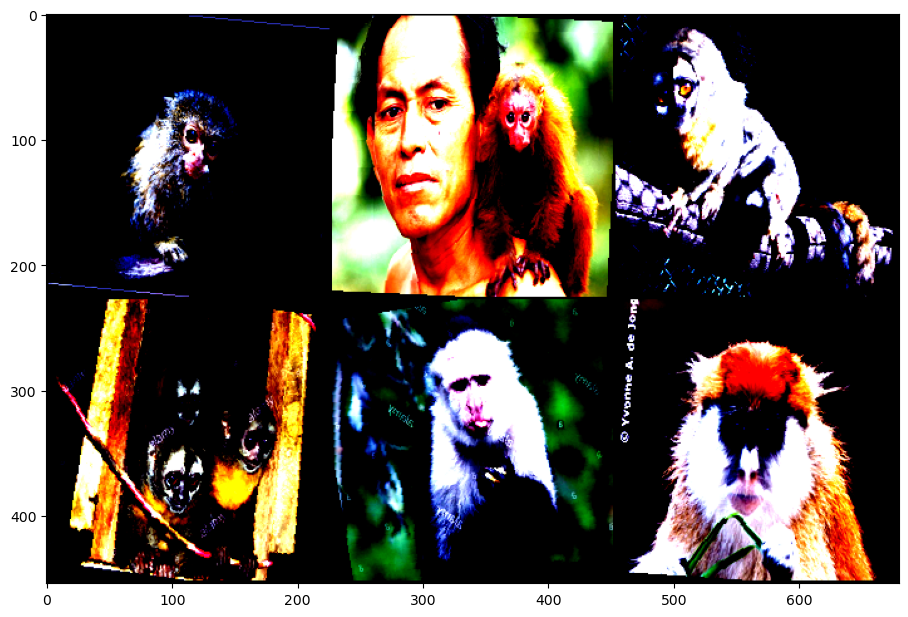

In [7]:
show_transformed_images(train_dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [9]:
# Define device function to parallel computing on GPU

def set_device():
    if torch.cuda.is_available():
        dev = "cuda"
    else:
        dev = "cpu"
    return torch.device(dev)

In [10]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print("Epoch no: %d " % (epoch + 1))
        
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            # Back propagate to calculate weight gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.0 * running_correct / total
        
        print("Training dataset. Got %d out of %d images correct (%.3f%%). Epoch loss: %3f" % (running_correct, total, epoch_accuracy, epoch_loss))
        
        test_dataset_accuracy = evaluate_model_on_test_set(model, test_loader)
        
        if (test_dataset_accuracy > best_accuracy):
            best_accuracy = test_dataset_accuracy
            save_checkpoint(model, epoch, optimizer, best_accuracy)
        
    print("Finished")
    return model

In [11]:
def save_checkpoint(model, epoch, optimizer, best_accuracy):
    state = {
        "epoch": epoch + 1,
        "model": model.state_dict(), # Only required attribute to save
        "best_accuracy": best_accuracy,
        "optimizer": optimizer.state_dict(), # Save optimizer state of you need to 'pause' to training
        "comments": "Very cool model!"
    }
    torch.save(state, "model_best_checkpoint.pth.tar")

In [12]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    # Deactivates autogradient engine. Won't be able to back propagate, but will evaluate on test set
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labes = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_accuracy = 100.0 * predicted_correctly_on_epoch / total
    print("Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_accuracy))
    return epoch_accuracy

In [13]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
num_classes = 10

# Linear function takes in inputs and other features to prepare necessary matrices for forward propagation
resnet18_model.fc = nn.Linear(num_ftrs, num_classes)

device = set_device()

# tell the ResNet18 model to go through the assigned device (CUDA)
resnet18_model = resnet18_model.to(device)

# Loss function shows the error during training process. Shows how far/close in terms of correctness.
loss_fn = nn.CrossEntropyLoss()

# SGD = Stochastic Gradient Descent, applies mini-batch gradient descent as long as you specify batch size above.
# LR stands for Learning Rate, determines how much to change model in response to estimated error, usually 0.001 - 0.01 works well.
# Momentum helps to accelerate graidnet vectors in right directions, leading to faster converging.
# Weight decay gives an extra error to loss function -- helps to precent overfitting.
optimizer = optim.SGD(resnet18_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 5)

Epoch no: 1 
Training dataset. Got 243 out of 1097 images correct (22.151%). Epoch loss: 2.198187
Testing dataset. Got 61 out of 272 images correctly (22.426%)
Epoch no: 2 
Training dataset. Got 398 out of 1097 images correct (36.281%). Epoch loss: 1.893308
Testing dataset. Got 114 out of 272 images correctly (41.912%)
Epoch no: 3 
Training dataset. Got 472 out of 1097 images correct (43.026%). Epoch loss: 1.660139
Testing dataset. Got 107 out of 272 images correctly (39.338%)
Epoch no: 4 
Training dataset. Got 520 out of 1097 images correct (47.402%). Epoch loss: 1.513120
Testing dataset. Got 133 out of 272 images correctly (48.897%)
Epoch no: 5 
Training dataset. Got 573 out of 1097 images correct (52.233%). Epoch loss: 1.330092
Testing dataset. Got 133 out of 272 images correctly (48.897%)
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
checkpoint = torch.load("model_best_checkpoint.pth.tar")

In [22]:
print(checkpoint["epoch"])
print(checkpoint["comments"])
print(checkpoint["best_accuracy"])

4
Very cool model!
48.89705882352941


In [23]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint["model"])

torch.save(resnet18_model, "best_model.pth")